# Simulations

In [1]:
# Loads the necessary libraries
library(dplyr)
library(ggplot2)
library(patchwork)
library(latex2exp)
library(tidyr)
library(gridExtra)
library(knitr)
library(kableExtra)
library(permuco)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘kableExtra’


The following object is masked from ‘package:dplyr’:

    group_rows




## Indices

In [2]:
# Used indices

# Globally set
q <- 1

richness <- function(abundance) {
  length(abundance)
}

shannon <- function(abundance) {
  vegan::diversity(abundance, index = "shannon")
}

giniSimpson <- function(abundance) {
  vegan::diversity(abundance, index = "simpson")
}

trueDiversity <- function(abundances) {
  p <- abundances / sum(abundances)
  (sum(p^q))^(1 / (1 - q))
}


raoQuadratic <- function(abundance, diss) {
    divermeta::raoQuadratic(ab = abundance, diss = diss)
}

redundancy <- function(abundance, diss) {
  divermeta::redundancy(ab = abundance, diss = diss)
}


redundancyAverage <- function(abundance, diss, cluster_ids) {
    # Average redundancy of each individual cluster

    avg_redundancy <- 0
    for(clust in unique(cluster_ids))
    {        
        positions <- cluster_ids == clust
        local_ab <- abundance[positions]
        local_diss <- diss[positions, positions]
        avg_redundancy <- avg_redundancy +  sum(local_ab)*redundancy(local_ab, local_diss)
    }

    avg_redundancy/sum(abundance)
}




MAD <- function(clust, diss) {
  divermeta::metagenomic.alpha.index(clust = clust, diss = diss, representatives = NULL) 
}


# Main method for computing the indices
computeIndices <- function(response, category) {
  new_df <- data.frame(
    category = category,
    richness_unclustered = richness(response$ab),
    richness_clustered = richness(response$ab_unit),
    shannon_unclustered = shannon(response$ab),
    shannon_clustered = shannon(response$ab_unit),
    giniSimpson_unclustered = giniSimpson(response$ab),
    giniSimpson_clustered = giniSimpson(response$ab_unit),
    redundancy_unclustered = redundancy(response$ab, response$diss),
    redundancy_clustered = redundancy(response$ab_unit, response$diss_units),
    redundancy_average = redundancyAverage(response$ab, response$diss, response$complete_ab$unit),
    MAD = MAD(clust = response$complete_ab$unit, diss = response$diss),
    multiplicity = divermeta::multiplicity.inventory(ab = response$ab, clust = response$complete_ab$unit, q = q),
    multiplicity_distance = divermeta::multiplicity.distance(ab = response$ab, diss = response$diss, clust = response$complete_ab$unit, method = "sigma", sig = 1),
    depth = sum(response$ab)
  )

  return(new_df)
}





## Build Objects


In [3]:

# Given a configuration, builds the elements necessary for computing al the indices
# total_abundance is set globally 
buildObjects <- function(configuration) {
  # First Creates df
  df <- data.frame(
    unit = character(),
    sub_unit = character(),
    abundance = numeric()
  )

  # Extracts the number of clusters (units)
  num_clust <- configuration[["n_units"]]()

  # Creates the abundance array randomly
  abundance_array <- as.vector(t(rmultinom(1, size = total_abundance, prob = sample(1:5, num_clust, replace = TRUE))))

  all_tot_n_subunits <- c()
  
  # Loops to append data
  # Creates each cluster with the number of elements (subunits) randomly
  for (i in 1:num_clust) {

    tot_n_subunits <- configuration[["n_subunits"]]()
    all_tot_n_subunits <- c(all_tot_n_subunits, tot_n_subunits)
    new_df <- data.frame(
      unit = i,
      sub_unit = sapply(1:tot_n_subunits, function(s) {
        return(paste(i, s, sep = "_"))
      }),
      abundance = configuration[["abundance"]](tot_n_subunits, abundance_array[i])
    )

    df <- rbind(df, new_df)
  }


  # Computes dissimilarity at a subunit level
  diss <- expand.grid(df$sub_unit, df$sub_unit)
  diss[] <- lapply(diss, as.character)

  diss <- diss[diss$Var1 >= diss$Var2, ]

  diss["same"] <- apply(diss, 1, function(row) {
    return(strsplit(row["Var1"], "_")[[1]][[1]] == strsplit(row["Var2"], "_")[[1]][[1]])
  })

  diss[diss$same, "dissimilarity"] <- configuration[["intra_distance"]](sum(diss$same))
  diss[!diss$same, "dissimilarity"] <- configuration[["inter_distance"]](sum(!diss$same))
  diss[diss$Var1 == diss$Var2, "dissimilarity"] <- 0

  # Extracts the mean intra distance  
  mean_distance <- mean(diss[diss$same, "dissimilarity"] )

  # Add the other copy (Lower trianlguar matrix)
  diss2 <- diss[, c("Var2", "Var1", "same", "dissimilarity")]
  colnames(diss2) <- c("Var1", "Var2", "same", "dissimilarity")
  diss2 <- diss2[diss2$Var1 != diss2$Var2, ]

  diss <- rbind(diss, diss2)

  # Constructs Dissimilarity at a unit level
  diss_unit <- merge(diss, df[, c("unit", "sub_unit")], by.x = "Var1", by.y = "sub_unit")

  diss_unit <- diss_unit[, c("unit", "Var2", "dissimilarity")]
  names(diss_unit) <- c("Var1", "Var2", "dissimilarity")

  diss_unit <- merge(diss_unit, df[, c("unit", "sub_unit")], by.x = "Var2", by.y = "sub_unit")

  diss_unit <- diss_unit[, c("Var1", "unit", "dissimilarity")]
  names(diss_unit) <- c("Var1", "Var2", "dissimilarity")

  diss_unit <- diss_unit %>%
    group_by(Var1, Var2) %>%
    summarise(dissimilarity = mean(dissimilarity), .groups = "drop")

  df_unit <- df %>%
    select(unit, abundance) %>%
    group_by(unit) %>%
    summarise(abundance = sum(abundance), .groups = "drop")

  response <- list()

  # Converts into the expected representation
  ab <- df$abundance

  ab_unit <- df_unit$abundance
  
  # Converts dataframes into matrices
  # Units
  wide_table_units <- diss_unit %>%
    pivot_wider(names_from = Var1, values_from = dissimilarity)

  unit_order <- wide_table_units$Var2

  matrix_units <- as.matrix(wide_table_units[, -1])
  diag(matrix_units) <- 0


  # Subunits
  wide_table <- diss %>%
    select(Var1, Var2, dissimilarity) %>%
    pivot_wider(names_from = Var1, values_from = dissimilarity)

  sub_unit_order <- wide_table$Var2

  matrix <- as.matrix(wide_table[, -1])
  diag(matrix) <- 0


  # Constructs response
  response$complete_ab <- df
  response$ab <- ab
  response$ab_unit <- ab_unit
  response$diss <- matrix
  response$diss_units <- matrix_units
  response$sub_unit_order <- sub_unit_order
  response$unit_order <- unit_order
  response$final_parameters <- c(
    "subunits" = mean(all_tot_n_subunits),
    "units" = num_clust,
    "distance" = mean_distance
  )

  return(response)
}





## Configuration

In [4]:
total_abundance <- 10000 # Total abundance for each scenario

# Inter Cluster distance (set to 1)
min_iter <- 1
max_inter <- 1

# Text codification of the scenarios
LOW <- "Low"
HIGH <- "High"

options <- c(LOW, HIGH)

option_val_map <- c()
for(i in 1:length(options))
{
  option_val_map[options[i]] = i-1

}


# Scenario Name Function
get_scenario_name <- function(i, subunits, units, intra_disimilarity)
{
  labe_map <- c(
    "Low" = "Few",
    "High" = "Many"
  )

  label <- paste(i, labe_map[subunits], "Subunits", "-", labe_map[units], "Units","-",  intra_disimilarity ,"Distance", sep = " ")
  return(label)
}


fixed_params <- c(
  "inter_distance" = function(x = 1) {
    runif(x, min = min_iter, max = max_inter)
  },
    "abundance" = function(x = 1, tot_abun) {
    as.vector(t(rmultinom(1, size = tot_abun, prob = sample(1:5, x, replace = TRUE))))
  }
)


# Units
units_params <- c(
  "Low" = function(x = 1) {    
    ceiling(abs(rnorm(n = x, mean = 20, sd = 15)))

  },
  "High" = function(x = 1) {    
    ceiling(abs(rnorm(n = x, mean = 50, sd = 15)))

  }
)



# Subunits
subunits_params <- c(
  "Low" = function(x = 1) {    
    ceiling(abs(rnorm(n = x, mean = 3, sd = 2)))

  },
  "High" = function(x = 1) {    
    ceiling(abs(rnorm(n = x, mean = 9, sd = 2)))

  }
)

# Intra Dissimilarity
intra_distance_params <- c(
  "Low" = function(x = 1) {    
    abs(rnorm(n = x, mean = 0.35, sd = 0.20))

  },
  "High" = function(x = 1) {
    abs(rnorm(n = x, mean = 0.7, sd = 0.20))
    
  }
)


scenarios <- c()
scenarios_names <- c()
df_scenario_parameters <- data.frame()

i <- 1
for(subunits_option in options)
{
  for(units_option in options)
  {
    for(intra_disimilarity_option in options)
    { 

        sce <- c("n_units" = units_params[[units_option]], 
                      "n_subunits" = subunits_params[[subunits_option]],
                      "intra_distance" = intra_distance_params[[intra_disimilarity_option]],
                      fixed_params
                      )

        scenarios <- c(scenarios, list(sce))

        scenario_name <- get_scenario_name(i, subunits_option, units_option, intra_disimilarity_option)
        scenarios_names <- c(scenarios_names, scenario_name) 
        df_scenario_parameters <- rbind(df_scenario_parameters, data.frame(scenario = scenario_name, 
                                                                           subunits_group = subunits_option,
                                                                           subunits_binary = option_val_map[subunits_option], 
                                                                           units_group = units_option,
                                                                           units_binary = option_val_map[units_option], 
                                                                           distance_group = intra_disimilarity_option,
                                                                           distance_binary = option_val_map[intra_disimilarity_option] 
                                                                           ))
        i <- i+1                   
  
    }
  }
}




## Excecution

In [5]:
tot <- 1000 # Total iterations by scenario
set.seed(1)

# Excecute
df <- data.frame()


# Simulate
# -----------

for(i in 1:length(scenarios_names))
{
  scenario <- scenarios[[i]]
  label <- scenarios_names[i]
  print(label)
  for (j in 1:tot)
  {
    print(paste("   ", j))
    flush.console()
    response <- buildObjects(scenario)
    new_df <- computeIndices(response, label)
    new_df["units"] = response$final_parameters["units"]
    new_df["subunits"] = response$final_parameters["subunits"] 
    new_df["distance"] = response$final_parameters["distance"]
    df <- rbind(df, new_df)
  }
  print("")

}

# Save to file
write.csv(df, paste("simulations_", tot, ".csv", sep = ""), row.names = FALSE)



# Load a specific file
# ------------------
#  df <- read.csv("simulations_200.csv")


# Loads all historic files
# -----------------------


files <- list.files(pattern = "simulations_.*\\.csv")
if (length(files) > 0) {
  df <- do.call(rbind, lapply(files, read.csv))
} else {
  stop("No simulation files found.")
}

print(nrow(df))

head(df)



[1] "1 Few Subunits - Few Units - Low Distance"
[1] "    1"
[1] "    2"
[1] "    3"
[1] "    4"
[1] "    5"
[1] "    6"
[1] "    7"
[1] "    8"
[1] "    9"
[1] "    10"
[1] "    11"
[1] "    12"
[1] "    13"
[1] "    14"
[1] "    15"
[1] "    16"
[1] "    17"
[1] "    18"
[1] "    19"
[1] "    20"
[1] "    21"
[1] "    22"
[1] "    23"
[1] "    24"
[1] "    25"
[1] "    26"
[1] "    27"
[1] "    28"
[1] "    29"
[1] "    30"
[1] "    31"
[1] "    32"
[1] "    33"
[1] "    34"
[1] "    35"
[1] "    36"
[1] "    37"
[1] "    38"
[1] "    39"
[1] "    40"
[1] "    41"
[1] "    42"
[1] "    43"
[1] "    44"
[1] "    45"
[1] "    46"
[1] "    47"
[1] "    48"
[1] "    49"
[1] "    50"
[1] "    51"
[1] "    52"
[1] "    53"
[1] "    54"
[1] "    55"
[1] "    56"
[1] "    57"
[1] "    58"
[1] "    59"
[1] "    60"
[1] "    61"
[1] "    62"
[1] "    63"
[1] "    64"
[1] "    65"
[1] "    66"
[1] "    67"
[1] "    68"
[1] "    69"
[1] "    70"
[1] "    71"
[1] "    72"
[1] "    73"
[1] "    74"

,category,richness_unclustered,richness_clustered,shannon_unclustered,shannon_clustered,giniSimpson_unclustered,giniSimpson_clustered,redundancy_unclustered,redundancy_clustered,redundancy_average,MAD,multiplicity,multiplicity_distance,depth,units,subunits,distance
,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>
1,1 Few Subunits - Few Units - Low Distance,42,11,3.451231,2.272453,0.9593690,0.8866795,0.047318180,-1.110223e-16,0.4070675,0.3193803,3.250397,1.288476,10000,11,3.818182,0.2304845
2,1 Few Subunits - Few Units - Low Distance,154,44,4.645664,3.670834,0.9871155,0.9726461,0.009480351,-1.110223e-16,0.3540562,0.3489141,2.650716,1.223075,10000,44,3.500000,0.2114080
3,1 Few Subunits - Few Units - Low Distance,188,57,4.906845,3.933579,0.9900752,0.9786883,0.007227617,0.000000e+00,0.3363425,0.3654547,2.646574,1.242491,10000,57,3.298246,0.2176188
4,1 Few Subunits - Few Units - Low Distance,92,25,4.124305,3.103114,0.9781798,0.9516679,0.016394824,0.000000e+00,0.3513163,0.3356606,2.776498,1.264742,10000,25,3.680000,0.2416052
5,1 Few Subunits - Few Units - Low Distance,45,15,3.392980,2.589703,0.9553300,0.9193747,0.021598129,0.000000e+00,0.2836337,0.4067919,2.232846,1.216653,10000,15,3.000000,0.2218709
6,1 Few Subunits - Few Units - Low Distance,79,19,4.114570,2.818777,0.9797791,0.9349216,0.029817684,0.000000e+00,0.4507579,0.2947071,3.653893,1.300565,10000,19,4.157895,0.2287349


## Plots

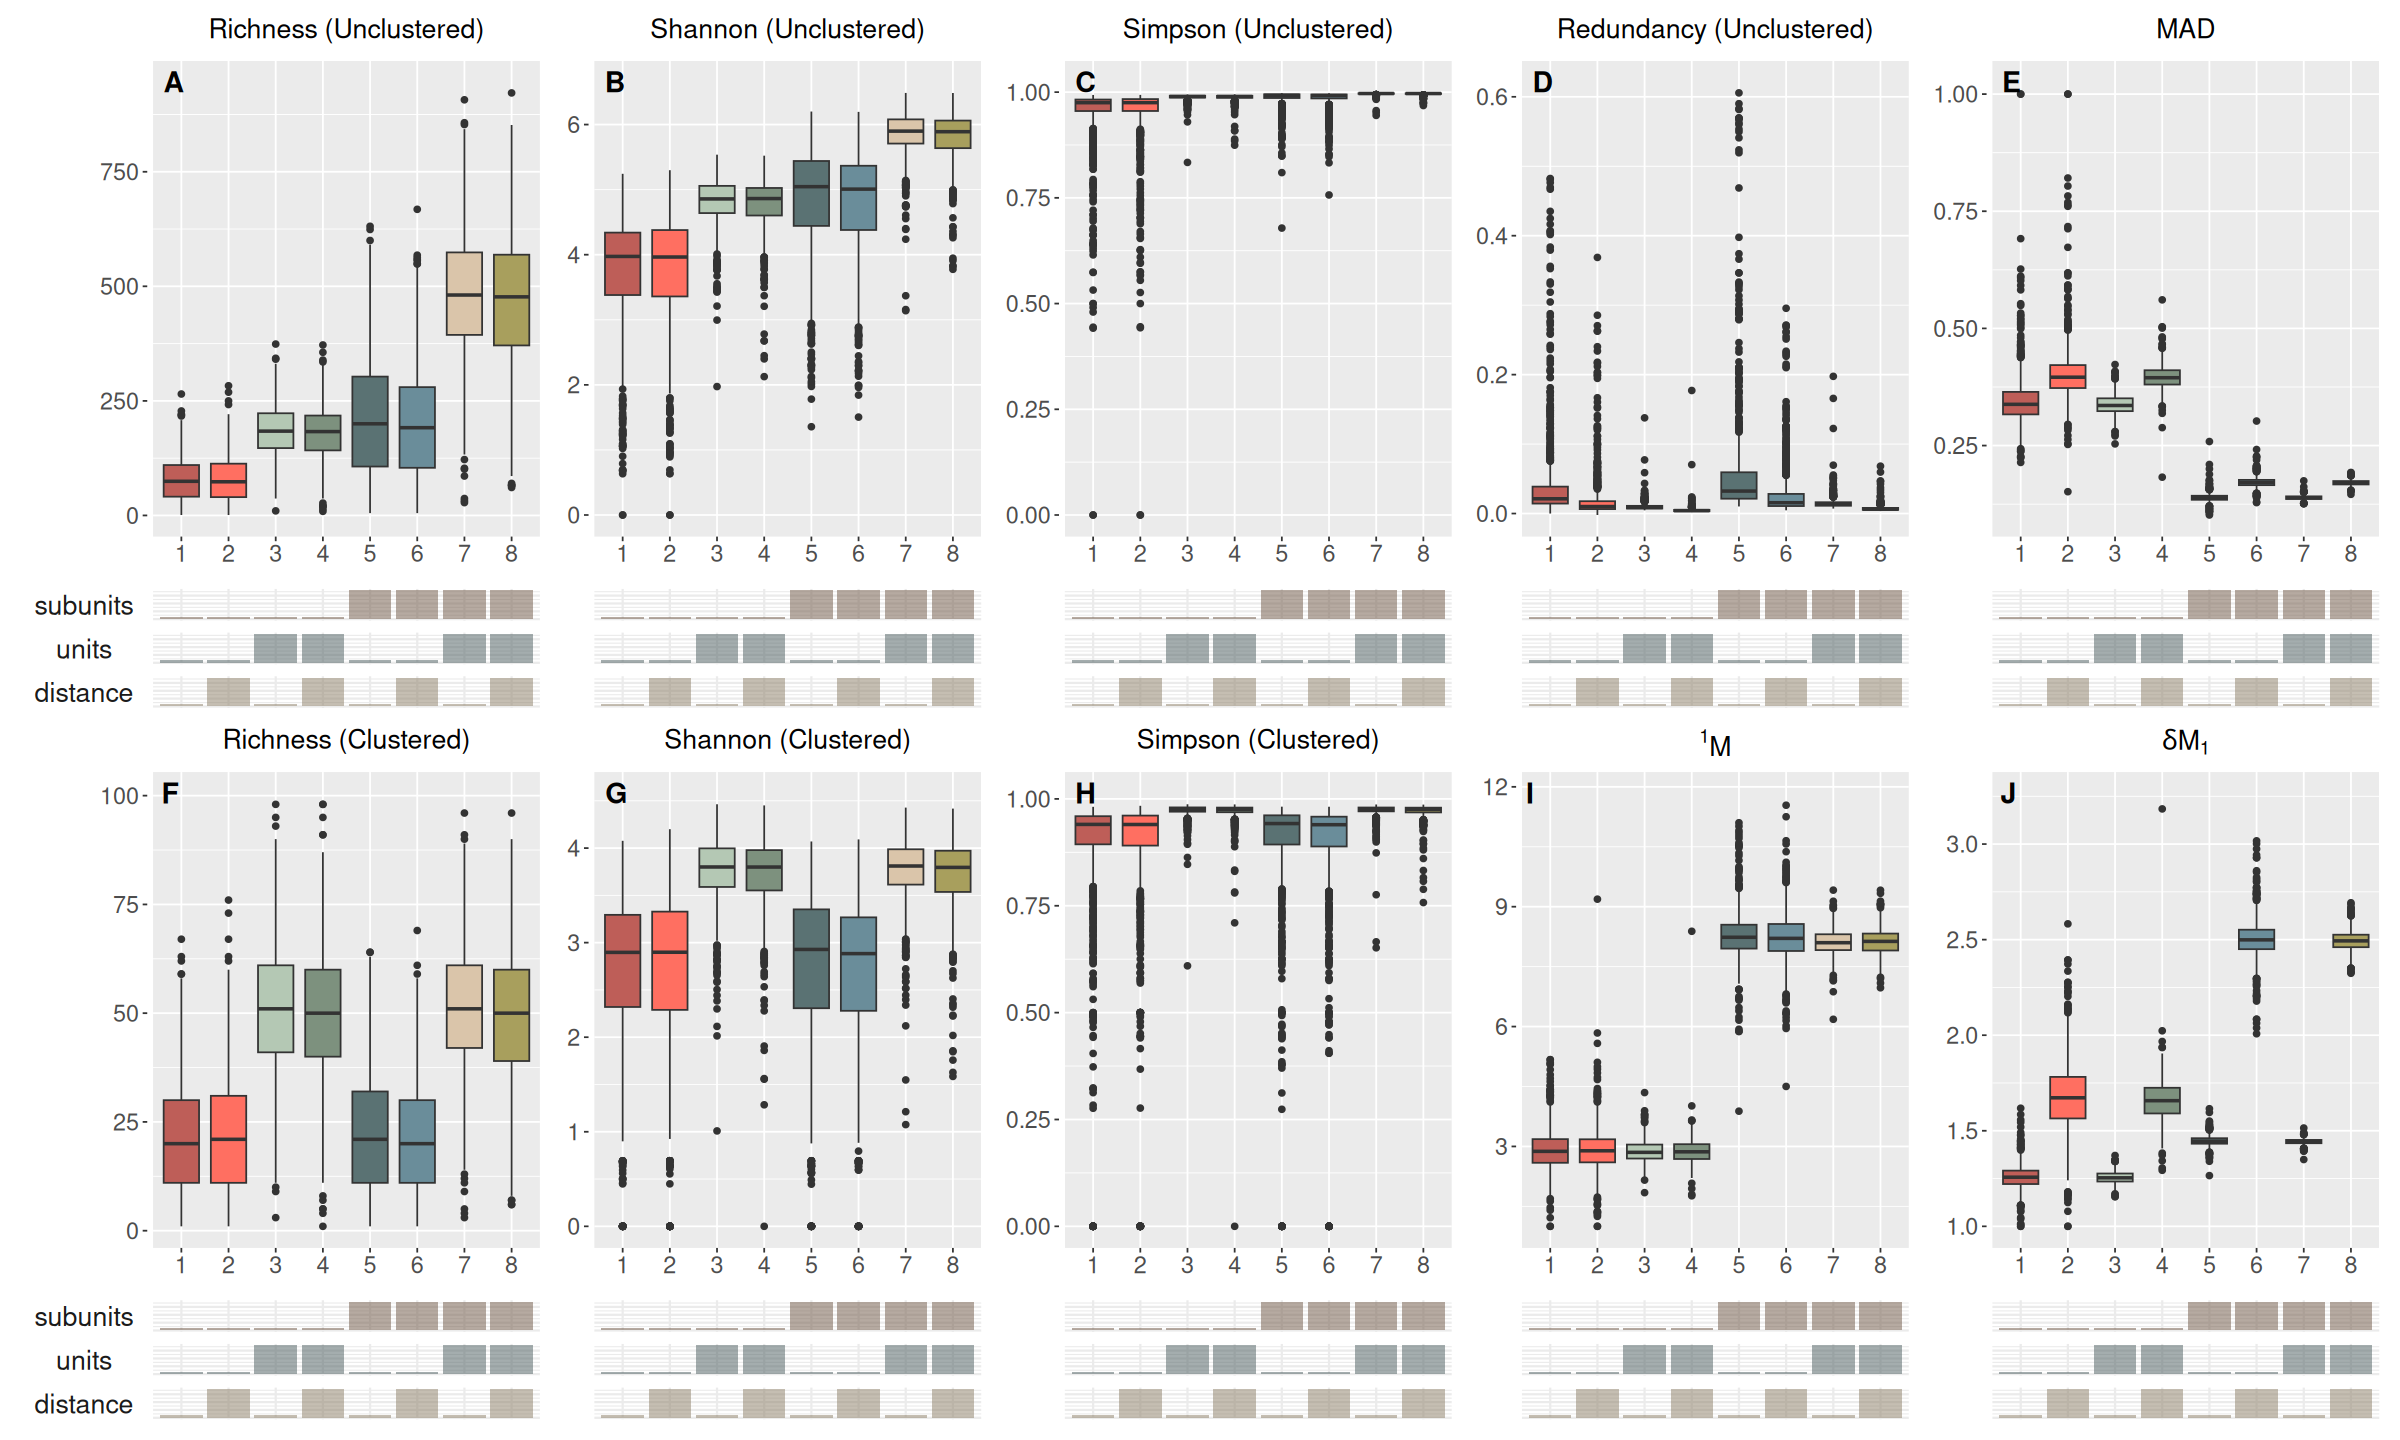

In [6]:



make_legend <- function(show_labels = TRUE) {



  df_legend <- df_scenario_parameters %>% select(scenario, subunits_binary, units_binary, distance_binary)
  df_legend[, c("subunits_binary", "units_binary", "distance_binary")] <- df_legend[, c("subunits_binary", "units_binary", "distance_binary")] + 0.1 
  df_legend  <- df_legend %>% rename(subunits = subunits_binary, units = units_binary, distance = distance_binary )

  # Reshape to long format and order parameter factor
  df_long <- df_legend %>%
    pivot_longer(cols = c(subunits, units, distance),
                 names_to = "parameter",
                 values_to = "value") %>%
    mutate(parameter = factor(parameter, levels = c("subunits", "units", "distance")))

  # Define custom colors
  custom_colors <- c(
    subunits = "#6F5745",
    units = "#4A5D5E",
    distance = "#8B7E66"
  )

  # Base plot
  p <- ggplot(df_long, aes(x = scenario, y = value, fill = parameter)) +
    geom_col(show.legend = FALSE, alpha = 0.5) +
    facet_wrap(~ parameter, nrow = 3, strip.position = "left") +
    scale_fill_manual(values = custom_colors) +
    theme_minimal(base_size = 14) +
    theme(
      axis.title = element_blank(),
      axis.text = element_blank(),
      axis.ticks = element_blank(),
      strip.placement = "outside",
      strip.text.y.left = element_text(
        angle = 0, 
        hjust = 0.5, 
        size = if (show_labels) 16 else 0  # hide labels by setting size to 0
      ),
      panel.spacing = unit(0.5, "lines")
    )

  return(p)
}


options(repr.plot.width = 20, repr.plot.height = 12)

# Create a list to store individual plots
plot_list <- list()


index_name <- c(
  "richness_unclustered" = "Richness (Unclustered)",
  "shannon_unclustered" = "Shannon (Unclustered)",
  "giniSimpson_unclustered" = "Simpson (Unclustered)",
  "redundancy_unclustered" = "Redundancy (Unclustered)",
  "MAD" = "MAD",
  "richness_clustered" = "Richness (Clustered)",
  "shannon_clustered" = "Shannon (Clustered)",
  "giniSimpson_clustered" = "Simpson (Clustered)",
  "multiplicity" = "$^1M$",
  "multiplicity_distance" = "$\\delta M_1$"
)

# Set custom colors
custom_colors <- c(
  "#BE5E58",
  "#FF6F61",
  "#B4C8B4",
  "#7D917E",
  "#5A7273",
  "#6A8D9A",
  "#DAC5AA",
  "#A89F5D"
)

custom_colors <- setNames(custom_colors, scenarios_names)
i <- 1
# Loop through each column (excluding "x" column)
for (col in names(index_name)) {
  # Create scatterplot for each column

  if (col %in% c("depth", "units", "subunits", "distance")) {
    next
  }

  p <- ggplot(df, aes(x = category, y = !!sym(col), fill = category)) +
    scale_fill_manual(values = custom_colors, name = "Scenario") +
    geom_boxplot() +
    labs(title = TeX(index_name[[col]])) +
    theme(legend.position = "none", 
          plot.title = element_text(size = 16, hjust = 0.5),
          axis.text = element_text(size = 14)) +  # Increase axis label font size
    labs(x = NULL, y = NULL) + # Remove x and y labels
    scale_x_discrete(labels = seq(1, length(scenarios_names))) +
    # theme(axis.text.x = element_blank()) + 
    # Add a label for the plot (A, B, C, D, ...)
    annotate("text", x = -Inf, y = Inf, label = LETTERS[i], 
             hjust = -0.5, vjust = 1.5, size = 6, fontface = "bold") +
    # Set limits to create space above the boxplots
    ylim(NA, max(df[[col]], na.rm = TRUE) + max(df[[col]])*0.025)  # Adjust the 1 as needed for

  # Add plot to the list
  # plot_list[[col]] <- p
  plot_list[[col]] <- p / make_legend(i == 1 || i == 6) + plot_layout(heights = c(4, 1))

  i  <-  i + 1
}



# Now arrange using patchwork with guide_area
final_plot <- wrap_plots(plotlist = plot_list, nrow = 2, ncol = 5, guides = "collect") 


# Print
print(final_plot)

## Hipothesis Test
Permutation ANOVA

In [8]:

DEBUG <- FALSE
np <- 10000

# Fixes seed
set.seed(1)


df_test <- df_scenario_parameters %>%
  rename(
    category = "scenario"
  ) %>%
  inner_join(df, by = "category")

for (target_col in names(index_name)) {

  cat(paste("% -----", target_col, "\n"))
  cat("\n\n")
  flush.console()
  
  # Rename back the categorical variables for discrete analysis
  df_perm <- df_test %>%
            select(-subunits, -units, -distance) %>%
            rename(
            subunits = subunits_group,
            units = units_group,
            distance = distance_group
            )
  
  # Permutation ANOVA using aovperm from permuco
  formula_perm <- as.formula(paste(target_col, "~ subunits * units * distance"))
  
  # Run permutation ANOVA
  perm_model <- aovperm(
    formula_perm,
    data = df_perm,
    np = np,        # number of permutations
    progress = FALSE
  )
  
  # Extract ANOVA table and compute eta²
  anova_df <- as.data.frame(perm_model$table)
  
  #  print(anova_df)
  
  anova_df <- anova_df %>%
    mutate(
      eta = round(SS / sum(SS) * 100, 2),
      `F value` = round(F, 2),
      `resampled Pr(>F)` = round(`resampled P(>F)`, 4)    
    ) %>%
    select(df, eta, SS, `F value`, `resampled Pr(>F)`)
  
  # Format for LaTeX
  anova_latex <- anova_df %>%
    mutate(
      `resampled Pr(>F)` = case_when(
        `resampled Pr(>F)` < 0.001 ~ paste0(sprintf("%.4f", `resampled Pr(>F)`), " ***"),
        `resampled Pr(>F)` < 0.01  ~ paste0(sprintf("%.4f", `resampled Pr(>F)`), " ** "),
        `resampled Pr(>F)` < 0.05  ~ paste0(sprintf("%.4f", `resampled Pr(>F)`), " *  "),
        TRUE             ~ sprintf("%.4f", `resampled Pr(>F)`)
      ),
      `SS`  = sprintf("%.2f", SS),
      eta = sprintf("%.2f", eta),
      `F value`  = sprintf("%.2f", `F value`)
    ) %>%
    rename(
      `Degrees of Freedom` = df,
      `Sum Sq` = `SS`,
      `$\\eta^2$` = eta,
      `p-value (Resampled)` = `resampled Pr(>F)`
    )
  
  tab <- kable(anova_latex, format = "latex", booktabs = TRUE,
               caption = paste(index_name[target_col], "simulation permutation ANOVA results."),
              #  label = paste0("tab:anova_results_", target_col),
               align = c("r", "r", "r", "r", "l"), escape = FALSE) %>%
    kable_styling(latex_options = c("hold_position"))
  
  if(!DEBUG)
  {
      cat(gsub("end{tabular}", paste0("end{tabular}\n\\label{","tab:anova_results_", target_col, "}"), tab,fixed = TRUE))
      cat("\n\n")
  }
  else {
     print(anova_latex)
      cat("\n\n")

  }
}

% ----- richness_unclustered 


\begin{table}[!h]
\centering
\caption{Richness (Unclustered) simulation permutation ANOVA results.}
\centering
\begin{tabular}[t]{lrrrrl}
\toprule
  & Degrees of Freedom & $\eta^2$ & Sum Sq & F value & p-value (Resampled)\\
\midrule
subunits & 1 & 34.84 & 88904270.30 & 8632.53 & 0.0001 ***\\
units & 1 & 27.55 & 70296563.40 & 6825.73 & 0.0001 ***\\
distance & 1 & 0.03 & 67227.81 & 6.53 & 0.0096 **\\
subunits:units & 1 & 5.32 & 13564939.12 & 1317.14 & 0.0001 ***\\
subunits:distance & 1 & 0.02 & 38698.00 & 3.76 & 0.0529\\
\addlinespace
units:distance & 1 & 0.01 & 13726.18 & 1.33 & 0.2455\\
subunits:units:distance & 1 & 0.00 & 0.28 & 0.00 & 0.9968\\
Residuals & 7992 & 32.25 & 82307653.81 & NA & NA\\
\bottomrule
\end{tabular}
\label{tab:anova_results_richness_unclustered}
\end{table}

% ----- shannon_unclustered 


\begin{table}[!h]
\centering
\caption{Shannon (Unclustered) simulation permutation ANOVA results.}
\centering
\begin{tabular}[t]{lrrrrl}
\toprule
